<a href="https://colab.research.google.com/github/hs0224/a-professor-student-research-club/blob/main/private/Mr_Mink/Chap04Deeper0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4장 숫자 분류기의 학습 내부 들여다보기
##### * 3장은 윤리관련 내용...
## 4.1 픽셀: 커퓨터 영상 처리의 기본 토대

In [1]:
# MNIST 샘플 데이터 셋 다운로드
from fastai.vision.all import *

path = untar_data(URLs.MNIST_SAMPLE)

##### * MNIST는 손으로 쓴 숫자 이미지들

In [2]:
(path/'train').ls()

(#2) [Path('/root/.fastai/data/mnist_sample/train/3'),Path('/root/.fastai/data/mnist_sample/train/7')]

### (path/'train').ls()
##### * ls(): 해당 디렉토리의 내용을 확인할 수 있다.
##### - fastai에서 제공하는 L 클래스 객체를 반환한다.(L클래스는 list를 기능확장한 것)
##### - '목록(list)'과 '목록의 개수(len)'를 함께 출력한다.
##### * '3'과 '7'의 폴더를 확인할 수 있고, 이는 '데이터셋'으로 "레이블(label 또는 target)"이라고 한다.

### 3과 7을 분리해서 출력하고 확인해 보도록하자.

In [3]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

threes

(#6131) [Path('/root/.fastai/data/mnist_sample/train/3/10.png'),Path('/root/.fastai/data/mnist_sample/train/3/10000.png'),Path('/root/.fastai/data/mnist_sample/train/3/10011.png'),Path('/root/.fastai/data/mnist_sample/train/3/10031.png'),Path('/root/.fastai/data/mnist_sample/train/3/10034.png'),Path('/root/.fastai/data/mnist_sample/train/3/10042.png'),Path('/root/.fastai/data/mnist_sample/train/3/10052.png'),Path('/root/.fastai/data/mnist_sample/train/3/1007.png'),Path('/root/.fastai/data/mnist_sample/train/3/10074.png'),Path('/root/.fastai/data/mnist_sample/train/3/10091.png')...]

In [4]:
# 데이터셋중 하나 출력
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

### PIL(Python Imaging Library)가 제공하는 Image 클래스를 사용 중.
##### * PIL은 이미지 open, manipulate, print 할 때, 가장 널리 사용하는 패키지.
##### ** 주피터 노트북은 "PIL 라이브러리가 표현하는 이미지를 '즉시' 인식"할 수 있다.
##### *** 컴퓨터는 모든 것을 숫자로 표현한다. 따라서, 이미지를 구성하는 숫자를 확인하려면 '넘파이 배열' 혹은 '파이토치 텐서'로 나타내야 한다.

In [5]:
# 넘파이 array 변환
array(im3)[4:10, 4:10] #슬라이싱

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [6]:
# 파이토치 tensor로 표현
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

##### * array는 Numpy, tensor는 Pytorch로 비슷한 형태지만, 다르다는 것을 알 수 있다.
### 판다스 데이터프레임으로 숫자의 값에 따라 색상을 그라데이션 형태로 표현해보기
##### * 숫자 -> 그림

In [7]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### df = pd.DataFrame(im3_t[4:15, 4:22])
##### * pd는 pandas 를 의미.
##### ** DataFrame()으로 데이터프레임 생성.
##### *** im3_t[4:15, 4:22] 에서 4:15 은 4 ~ 14, 그리고 4:22 은 4 ~ 21 을 의미한다. 따라서, 데이터 프레임의 행은 0부터 (14 - 4 = )10, 열은 0부터 (21 - 4 = )17 까지의 범위를 표현하게 된다.
### df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')
##### * df.style: df의 스타일 클래스
##### ** .set_properties(): 속성 설정 함수
##### *** (**{'font-size':'6pt'}): **의 의미는 잘 모르겠지만, 폰트사이즈를 6포인트로 설정하겠다는 의미.
##### **** .background_gradient('Greys') 배경의 그라데이션을 'Greys(흑백)'으로 설정.
##### ***** 디자인적인 의미에서 그라데이션을 기울기로 나타낸다. 색이 진해질 수록 기울기가 높다.
### 숫자 -> 그림 분석
##### * 완전 흰색은 0!, 완전 검은색은 255!
##### ** 이미지는 28 x 28 이다.
##### *** 즉, 가로 28개, 세로 28개의 픽셀들(784개)로 구성된다는 뜻이다.

## 4.2 첫번째 시도: 픽셀 유사성
#### 시도 1: 숫자 3과 7에 대한 모든 이미지의 평균 픽셀값 구하기
##### 두 숫자에 대해 얻은 '평균 픽셀값'은 "이상적인" 3과 7로 정의해볼 수 있다.
### ① 평균 픽셀값 구하기:

In [8]:
# 모든 숫자 3 이미지를 쌓아 올린 텐서를 만들어 보기.
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

### seven_tensors = [tensor(Image.open(o)) for o in sevens]
##### * list[] 안에 for문: 리스트 컴프리헨션
##### ** 통상적인 반복문 사용과 비교해 코드의 양도 더 적고, 속도도 월등히 빠름.

### ② 리스트 제대로 만들어졌는지 확인하기
##### * 위에서 tensor(Image.open(o)) 코드를 통해 tensor 형식으로 이미지가 생성되었으므로, 출력하려면 fastai가 제공하는 show_image 함수를 사용 해야한다.

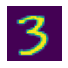

In [9]:
show_image(three_tensors[1]);

##### ! 우리의 목표는 "각 픽셀 위치의 전체 평균을 계산 -> 각 픽셀의 강도 구하기".
##### /_> 리스트 내의 모든 이미지를 "3차원 텐서 '하나로' 결합" 해야 한다.
##### * 일반적으로 3차원 텐서는 '랭크3 텐서' 라고 한다.
##### ** stack(): 컬렉션에 담긴 개별 텐서들을 쌓아올려 단일 텐서로 만드는 역할 (파이토치 제공)
##### *** (파이토치 제공) '일부' 연산은 '부동 소수형 데이터만' 을 지원. => 작업에 따라 '형변환'을 해야 한다.

In [10]:
# 픽셀값을 부동소수로 표현할 때는 값을 0 ~ 1 로 맞춰줘야 한다.
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

### stacked_threes.shape
##### * tensor.shape: "각 축의 길이를 표현" 하는 텐서의 '속성'
##### ** 텐서를 구성하는 '각 축의 의미'는 순전히 텐서를 만드는 '우리가 정한다'.
##### *** 랭크: 텐서의 차원 또는 축의 개수, shape: 각 축의 크기를 표현. 따라서, '랭크 = 텐서' 로 여길 수 있다.

In [11]:
len(stacked_threes.shape)

3

In [12]:
# ndim 속성으로 rank를 바로 확인가능.
stacked_threes.ndim

3

### ③ 각 픽셀의 위치에 대한 모든 이미지의 평균을 구하고, 한 장의 이미지로 만들기.
##### * 쌓아 올린 랭크3 텐서에서 0번째 차원의 평균을 구해, 모든 이미지 텐서의 평균을 구함.

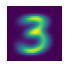

In [13]:
mean3 = stacked_threes.mean(0)
show_image(mean3);
# ';'를 주의

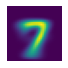

In [14]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

### ④ 이상적인 숫자들과의 '거리' 구하기
##### * 얼마나 수정해야 비교대상과 같아지는가?

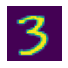

In [15]:
# 임의로 숫자 3 샘플 하나 선택
a_3 = stacked_threes[1]
show_image(a_3);

##### * 일부 차이에서는 +, 일부 차이에서는 - 가 발생할 수 있다. 이 차이들을 합하면 상쇄되므로, 극단적으로는 더한 차이가 0 으로만 구성되는 결과를 얻을 수도 있다. 따라서, 2가지 방법의 해결책이 주로 사용된다.
##### ** L1 norm, 평균절대차(MAD: Mean Absolute Difference) - 차이의 절댓값에 대한 평균을 구하는(음수를 양수화) 방법.
##### *** L2 norm, 평균제곱근오차(RMSE: Root Mean Squared Error) - 차이의 제곱(모든 수를 양수화)에 대한 평균의 제곱근(제곱을 다시 원상태로 되돌림)을 구하는 방법.

In [16]:
# MAD
dist_3_abs = (a_3 - mean3).abs().mean()
# RMSE
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()

dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [17]:
# MAD
dist_7_abs = (a_3 - mean7).abs().mean()
# RMSE
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()

dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

### a_3 - mean7
##### * 선택한 숫자 3 이미지와 이상적인 숫자 7과의 거리가 이상적인 숫자 3과의 거리보다 더 짧다.
##### ** 파이토치는 이 두 방법(MAD, RMSE)에 대해 "손실 함수"를 제공한다.
##### *** torch.nn.functional 에서 찾아볼 수 있다.


In [18]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### F.l1_loss(): 절대평균값('L1 norm' or 'MAV(Mean Absolute Value)'
### F.mse_loss(): 평균제곱오차('MSE')
##### * 직관적으로, 'MSE'가 'L1 norm'보다 실수에 더 강한 패널티를 부여한다.

## 4.2.1 넘파이 배열과 파이토치 텐서
### Numpy 배열은
##### * '수치 프로그래밍'에서 가장 널리 사용되는 파이썬 라이브러리 이다.
##### ** 딥러닝에서 매우 중요한 GPU를 이용한 그레디언트 계산(미분) 같은 기능을 제공하지 않는다.
##### *** 다른 언어로 작성되었다.(최적화된 컴파일 단계로 만들어진 객체를 파이썬으로 래핑한 것)
##### **** 리스트 (1차원)/ 테이블 or 행렬 (2차원)/ 중첩 테이블 or 큐브 (3차원) 이상의 모든 형상을 표현할 수 있다.
##### ***** 내부적으로 모두 같은 자료형의 데이터를 C의 자료구조로 압축하여 메모리에 저장한다.
### .
### Pytorch 텐서는
##### Numpy가 제공하는 대다수의 연산자 및 메서드를 '같은 형식'으로 지원한다.
##### 'GPU에 적재'가 가능하다.
##### '자동 미분'이 가능하다.

In [19]:
#data = [[1,2,3],[4,5,6]]
data = [[1,2,3],
        [4,5,6]]
arr = array(data)
tns = tensor(data)

# Numpy Array
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [20]:
# Pytorch Tensor
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

In [21]:
# 두 번째 행
tns[1]

tensor([4, 5, 6])

In [22]:
# 아래 코드의 콜론은 "첫 번째 축'의 모든것"
tns[:, 1]

tensor([2, 5])

In [23]:
# 슬라이스 문법과 결합
tns[1, 1: 3]
# 행과 열의 일부를 자유자재로 선택 가능.
## 1은 2번째 행, 1: 3은 1부터 2번째 원소

tensor([5, 6])

In [24]:
tns + 1
# 원소 전체에 1을 더함.

tensor([[2, 3, 4],
        [5, 6, 7]])

In [25]:
tns.type()

'torch.LongTensor'

In [26]:
tns * 1.5
# 필요하면 자동으로 자료형을 바꿈.

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## 4.3 브로드캐스팅으로 평가지표 계산하기
##### * 평가지표: "데이터셋에 표기된 올바른 '레이블'"과 "모델이 도출한 '예측'"을 '비교해'서 "모델이 '얼마나 좋은지'를 '평가'하는 '단일' 숫자".
##### ** 앞에서 언급된 MSE, MAV, AVG 등을 평가지표로 사용할 수 도 있다.
##### *** 위 세 지표 모두 사람이 직관적으로 이해하기 쉽지 않으므로, 보통 '정확도(accuracy)'를 "분류 모델 평가지표"로 사용한다.

### 검증용 데이터셋(validation set) 평가지표 계산하기
##### (의도치 않게 학습용 데이터셋에서만 잘 작동하는 "과적합을 피하기 위해서")
##### * 검증용 데이터셋을 얻으려면, 학습에 사용되는 일부 데이터를 완전히 제거해야 한다.
##### ** MNIST 데이터셋에는 이미 검증용 데이터셋이 준비되어있다.
##### (valid라는 완전 분리된 디렉토리)

In [27]:
# '3' 검증용 데이터셋
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

# '7' 검증용 데이터셋
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

# shape속성: 각 축의 길이 표현
valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

##### * 궁극적인 목표: 임의로 입력된 이미지가 3또는 7인지 판단하는 'is_3 함수'를 만드는 것.

In [28]:
# 평균절대오차(MAD) 함수 만들기
def mnist_distance(a, b): return (a-b).abs().mean((-1, -2))
mnist_distance(a_3, mean3)

tensor(0.1114)

##### * a_3와 mean3는 단일 이미지를 표현하는 텐서이다.
##### ** 각각 임의의 숫자 3, 이상적인 숫자 3을 표현하며, 둘 다 [28, 28] 모양이다.
##### *** 계산 결과는 앞서 계산된 두 이미지 사이의 거리와 같음을 알 수 있다.
### .
### 그렇다면, 전체 이미지에 대한 평가지표를 계산하려면?
##### (검증용 데이터셋 내 모든 이미지와 이상적인 숫자 3 이미지의 거리를 계산해야만 한다.)

In [29]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1346, 0.1263, 0.1469,  ..., 0.1097, 0.1101, 0.1320]),
 torch.Size([1010]))

### !!! 오류가 생기지 않는다!? => !! 브로드캐스팅 !!
##### * 브로드캐스팅: 더 낮은 랭크의 텐서를 더 높은 랭크의 텐서와 같은 크기로 자동 확장한다.

In [30]:
(valid_3_tens - mean3).shape

torch.Size([1010, 28, 28])

In [31]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [32]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

### is_3(a_3)
##### * True 또는 False 반환
###is_3(a_3).float()
##### * .float()을 통해 부동소수화; True = 1.0, False = 0.0


In [33]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [34]:
accuracy_3s =       is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()
##### * '7'은 '3'과 반대되는 개념이므로 '1 - '를 통해 반전시킴.
##### ** '3', '7' 모두 90%가 넘는 정확도를 얻었음.
### .
### 실제로 무언가를 학습하는 시스템은 "스스로 '자동 수정'해나가는 방법"이 필요하다. -> SGD

## 4.4 확률적 경사 하강법
##### * 특정 이미지와 '이상적인 이미지' 사이의 유사도를 찾는 대신, 개별 픽셀'마다' 가중치를 설정하고, 숫자를 표현하는 "검은색 픽셀의 '가중치를 높이는' 방법"을 생각해보자.
##### ** '3' 이라면, 해당 부분이 높은 확률로 활성화 될것.
##### *** 따라서, 가중치는 '7'에서 낮게, '3'에서는 높게 매겨진다.

In [35]:
def pr_three(x, w): return (x*w).sum()

### x, w
##### x: 벡터; 2차원으로 표현된 픽셀의 각 행을 이어붙인 1차원의 긴 배열 (이라고 가정하자)
##### w: 벡터; 가중치
##### * 함수 정의 후, 가중치를 약간씩 조정하는 방법 생각할 것.

### 목표: 숫자 3에서는 높지만, 그 외의 숫자에서는 낮은 w 값을 찾는 것.
#### (머신러닝) 분류 모델로 만드는데 필요한 단계
##### ① 가중치를 '초기화(initialize)' 한다.
##### ② 현재 가중치로 이미지가 3 또는 7 인지를 '예측(predict)' 한다.
##### ③ 예측한 결과로 모델이 얼마나 좋은지 계산한다('손실' 측정).
##### ④ 가중치 갱신 정도가 손실에 미치는 영향을 측정하는 '그레디언트(gradient; 미분값, 기울기)'을 계산한다.
##### ⑤ '④'에서 계산한 그레디언트로 가중치 값을 '한 단계(step)' 조정한다.
##### ⑥ '②'로 돌아가서 과정을 '반복(repeat)'한다.
##### ⑦ 학습 과정을 멈춰도 좋다는 '판단'이 설 때까지 계속해서 반복한다.(모델 성능이 충분하다고 판단하거나, 시간상 제약으로 멈춰야 할지도 모름)
###.
##### .....................┎> [손실 측정] -> [그레디언트 계산] ┓
##### [초기화] -> [예측] <-------------------------- [가중치 한 단계 갱신] -> [훈련 종료]
##### (p.205 참고)

In [36]:
def f(x): return x**2

In [37]:
# why? then, what is plot_function?
# plot_function(f, 'x', 'x**2')

In [38]:
#plt.scatter(-1.5, f(-1.5), color='red');

## 4.4.1 그레디언트 계산
### - 학습의 마법이 일어날 때
##### * 파이토치는 거의 모든 함수에 대해 미분을 자동으로 계산해준다.

In [39]:
xt = tensor(3.).requires_grad_()

### requires_grad_()
##### * 파이토치에 특정 값의 변수에 대한 그레디언트를 계산해 달라고 하는 마법같은 함수.
##### ** 내부적으로, 변수에 '태그'를 붙이는 방법이다.
##### *** 파이토치는 태그 정보를 활요해 기존의 텐서에 추가 연산이 발생하더라도 모든 연산을 추적하여 그레디언트를 계산하는 방법을 기억한다.

In [40]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [41]:
yt.backward()

### backward(): 역전파
##### 우리가 계속 말해왔던 미분과정

In [42]:
# 실제 계산된 그레디언트를 알 수 있다.
xt.grad

tensor(6.)

In [43]:
xt = tensor([3., 4., 10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

##### 단일 숫자 대신 벡터를 입력해 그레디언트를 다시 구했다.
##### 이제, sum을 추가해, 벡터가 입력되었을 때, 스칼라값을 출력하도록 만들어주자.

In [44]:
def f(x): return (x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [45]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

##### * 그레디언트는 함수의 기울기만을 나타낸다. 따라서, 파라미터를 얼마나 조정해야 하는지를 알려주지는 않는다. 그렇다면 어떻게 알 수 있을까?

## 4.4.2 학습률을 사용해 단계 밟아 나가기
### 경사가 가파르면 조정을 더 많이, 경사가 완만하면 최적의 값에 가까울 것 같은데...
##### 학습률(LR: learning rate) 이라는 작은 값을 그레디언트에 곱해보자.(대부분 0.001 ~ 0.1 정도로 선택)

In [46]:
# w -= w.grad * lr

##### 이러한 과정은 보통 '최적화 단계(optimization step)'를 사용한 파라미터의 '갱신 단계(stepping)'라고 한다.
##### * 너무 작은 학습률 -> 많은 단계 수행 -> 연산량 증가, 오래 걸림
##### ** 너무 큰 학습률 -> 손실이 더 심해짐
##### *** 따라서, 적당한 크기의 학습률을 사용하는 것이 중요.

## 4.4.3 SGD를 활용한 시작부터 끝까지를 보여주는 예제

In [47]:
time = torch.arange(0, 20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

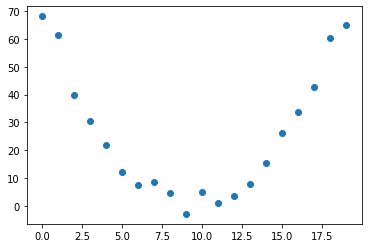

In [48]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed);

##### * 수작업 측정은 정확하지 않을 수 있어, 임의의 노이즈도 약간 추가함.

In [49]:
def f(t, params):
  a,b,c = params
  return a*(t**2) + (b*t) + c

In [50]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

### 1단계: 파라미터 초기화

In [51]:
params = torch.randn(3).requires_grad_()

### 2단계: 예측 계산

In [52]:
# 함수에 입력과 파라미터를 넣어서 예측 계산
preds = f(time, params)

In [53]:
# 예측과 실제 타깃의 유사도를 그래프로 확인하는 간단한 함수를 만든다.
def show_preds(preds, ax=None):
  if ax is None: ax=plt.subplots()[1]
  ax.scatter(time, speed)
  ax.scatter(time, to_np(preds), color='red')
  ax.set_ylim(-300, 100)

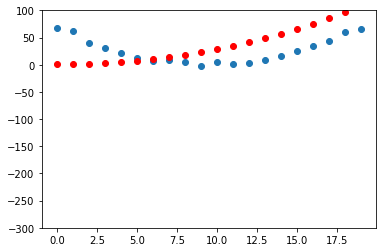

In [54]:
show_preds(preds)

##### 예측과 타깃이 완전히 다르다!?

### 3단계: 손실 계산

In [55]:
# 손실 계산
loss = mse(preds, speed)
loss

tensor(36.3867, grad_fn=<SqrtBackward0>)

##### 이제 계산된 손실값을 줄여서 성능을 높이는 것을 목표로 한다.(그래디언트 먼저 알아야함)

### 4단계: 그레디언트 계산
##### 파라미터 값이 바뀌어야 하는 정도를 추정하는 그레디언트를 계산한다.

In [56]:
loss.backward()
params.grad

tensor([121.4236,   7.8287,   0.2894])

In [57]:
params.grad * 1e-5

tensor([1.2142e-03, 7.8287e-05, 2.8935e-06])

##### 1e-5는 학습률.(0.00001)

In [58]:
params

tensor([ 0.3171, -0.4227,  0.9989], requires_grad=True)

### 5단계: 가중치를 한 단계 갱신하기

In [59]:
# 계산된 그레디언트에 기반하여 파라미터 값을 갱신
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

##### 손실이 개선되었는지 확인해보자.

In [60]:
preds = f(time, params)
mse(preds, speed)

tensor(36.2390, grad_fn=<SqrtBackward0>)

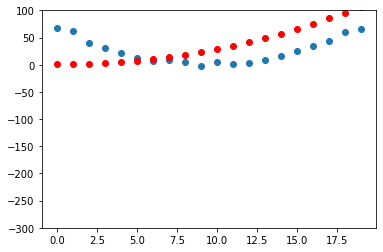

In [61]:
# 그리기
show_preds(preds)

##### 지금까지의 과정을 수차례 반복해야 하므로 모든 과정을 담은 함수를 만든다.

In [62]:
def apply_step(params, prn=True):
  preds = f(time, params)
  loss = mse(preds, speed)
  loss.backward()
  params.data -= lr * params.grad.data
  params.grad = None
  if prn: print(loss.item())
  return preds

### 6단계: 과정 반복하기

In [63]:
for i in range(10): apply_step(params)

36.238956451416016
36.092281341552734
35.946712493896484
35.802249908447266
35.65890121459961
35.51667785644531
35.37557601928711
35.2356071472168
35.096771240234375
34.959068298339844


##### 2차 함수의 모양이 잡혀가는 과정을 파악하자.

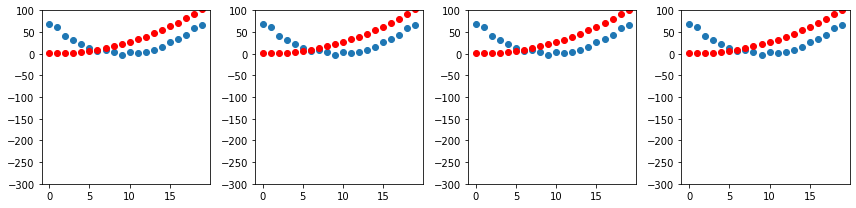

In [64]:
_, axs = plt.subplots(1, 4, figsize=(12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### 7단계: 학습 종료
#####  10번의 에포크 후 학습을 종료했다. 임의로 정한 횟수이기 때문에 큰 의미는 없지만, 실전에는 학습용과 검증용 데이터셋에 대한 손실 및 평가 지표를 주시하면서 학습 종료 시점을 결정해야한다.

## 잠시 복습
##### 1. 파라미터 초기화
##### 2. 예측 계산
##### 3. 손실 계산
##### 4. 그레디언트 계산
##### 5. 가중치를 한 단계 갱신
##### 6. 과정 반복
##### 7. 학습 종료